## **MultiRes UNet - Final Version 1**

* Learning rate = 0.0001
* Epochs = 100
* Batch Size = 8

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# from keras_unet.utils import get_patches
# from keras_unet.models import satellite_unet
import glob
import os
from keras import backend as K 
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json, load_model
import torch
from tensorflow.keras.optimizers import Adam
# from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
print(torch.cuda.is_available())

scaler = MinMaxScaler()

%matplotlib inline

True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb 11 10:39:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
train_image_paths_list = []
train_gt_paths_list = []
train_image_path = '/content/drive/MyDrive/airs-minisample/patch-png/train_images/train/'
train_label_path = '/content/drive/MyDrive/airs-minisample/patch-png/train_masks/train/'

for img_path in glob.glob(os.path.join(train_image_path, '*.png')):
    train_image_paths_list.append(str(img_path))   
print("Total aerial satellite images : ",len(train_image_paths_list))

for img_path in glob.glob(os.path.join(train_label_path, '*.png')):
    train_gt_paths_list.append(str(img_path))
print("Total segmented mask images : ",len(train_gt_paths_list))

train_image_paths_list.sort()
train_gt_paths_list.sort()

Total aerial satellite images :  1548
Total segmented mask images :  1548


In [ ]:
train_X = []
count = 0
for img in train_image_paths_list:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_X.append(resized_img)

In [ ]:
count = 0
train_Y = []
for img in train_gt_paths_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_Y.append(resized_img)
    
print(len(train_X), len(train_Y))

1548 1548


In [ ]:
val_image_paths_list = []
val_gt_paths_list = []
val_image_path = '/content/drive/MyDrive/airs-minisample/patch-png/val_images/val/'
val_label_path = '/content/drive/MyDrive/airs-minisample/patch-png/val_masks/val/'

for img_path in glob.glob(os.path.join(val_image_path, '*.png')):
    val_image_paths_list.append(str(img_path))        
print("Total aerial images in vaidation set : ",len(val_image_paths_list))

for img_path in glob.glob(os.path.join(val_label_path, '*.png')):
    val_gt_paths_list.append(str(img_path))        
print("Total segmented mask images in validation set : ",len(val_gt_paths_list))

val_image_paths_list.sort()
val_gt_paths_list.sort()

Total aerial images in vaidation set :  36
Total segmented mask images in validation set :  36


In [ ]:
val_X = []
val_Y = []
for img in val_image_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_X.append(resized_img)
    
for img in val_gt_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_Y.append(resized_img)
    
print(len(val_X), len(val_Y))

36 36


In [ ]:
test_image_paths_list = []
test_gt_paths_list = []
test_image_path = '/content/drive/MyDrive/airs-minisample/patch-png/test_images/test/'
test_label_path = '/content/drive/MyDrive/airs-minisample/patch-png/test_masks/test/'

for img_path in glob.glob(os.path.join(test_image_path, '*.png')):
    test_image_paths_list.append(str(img_path))        
print("Total aerial images in vaidation set : ",len(test_image_paths_list))

for img_path in glob.glob(os.path.join(test_label_path, '*.png')):
    test_gt_paths_list.append(str(img_path))        
print("Total segmented mask images in validation set : ",len(test_gt_paths_list))

test_image_paths_list.sort()
test_gt_paths_list.sort()

Total aerial images in vaidation set :  36
Total segmented mask images in validation set :  36


In [ ]:
test_X = []
test_Y = []
for img in test_image_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    test_X.append(resized_img)
    
for img in test_gt_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    test_Y.append(resized_img)
    
print(len(test_X), len(test_Y))

36 36


### **Perform scaling for images using Min Max Scaler**

In [ ]:
train_X = np.array(train_X)
train_Y = np.array(train_Y)

train_Y = train_Y.reshape((train_Y.shape[0],train_Y.shape[1],train_Y.shape[2],1))

train_X_scaler = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
train_Y_scaler = scaler.fit_transform(train_Y.reshape(-1, train_Y.shape[-1])).reshape(train_Y.shape)
print(train_X_scaler.shape, train_Y_scaler.shape)

(1548, 256, 256, 3) (1548, 256, 256, 1)


In [ ]:
val_X = np.array(val_X)
val_Y = np.array(val_Y)

val_Y = val_Y.reshape((val_Y.shape[0],val_Y.shape[1],val_Y.shape[2],1))

val_X = scaler.fit_transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape)
val_Y = scaler.fit_transform(val_Y.reshape(-1, val_Y.shape[-1])).reshape(val_Y.shape)
# val_X = val_X / 255.
# val_Y = val_Y / 255.

print(val_X.shape)
print(val_Y.shape)

(36, 256, 256, 3)
(36, 256, 256, 1)


In [ ]:
test_X = np.array(test_X)
test_Y = np.array(test_Y)

test_Y = test_Y.reshape((test_Y.shape[0], test_Y.shape[1], test_Y.shape[2],1))

test_X = scaler.fit_transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
test_Y = scaler.fit_transform(test_Y.reshape(-1, test_Y.shape[-1])).reshape(test_Y.shape)
# val_X = val_X / 255.
# val_Y = val_Y / 255.

print(test_X.shape)
print(test_Y.shape)

(36, 256, 256, 3)
(36, 256, 256, 1)


### **Performance Metrics while training the model**

In [ ]:
# def IOU(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# def dice_coef(y_true, y_pred):
#     smooth = 0.0
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def mcc(y_true, y_pred):
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0) * 1e2  # needs to be checked
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0) / 1e2

#     up = tp*tn - fp*fn
#     down = K.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))

#     mcc = up / (down + K.epsilon())
#     mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
#     return mcc

In [ ]:
def IOU(y_true, y_pred):
  smooth = 1.0
  # y_true = y_true.astype('float32')
  # y_pred = y_pred.astype('float32')
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  y_true_f = K.round(K.flatten(y_true))
  y_pred_f = K.round(K.flatten(y_pred))
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
  # jacc = intersection / (union + K.epsilon())
  jacc = (intersection + smooth) / (union + smooth)
  return jacc

def dice_coef(y_true, y_pred):
    smooth = 1.0
    # y_true = y_true.astype('float32')
    # y_pred = y_pred.astype('float32')
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.round(K.flatten(y_true))
    y_pred_f = K.round(K.flatten(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mcc(y_true, y_pred):
  smooth = 1.0
  # y_true = y_true.astype('float32')
  # y_pred = y_pred.astype('float32')
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  y_true_f = K.round(K.flatten(y_true))
  y_pred_f = K.round(K.flatten(y_pred))
  tp = K.sum(y_true_f * y_pred_f)
  tn = K.sum((1-y_true_f) * (1-y_pred_f))
  fp = K.sum((1-y_true_f)*y_pred_f)
  fn = K.sum(y_true_f * (1-y_pred_f))
  up = tp*tn - fp*fn
  down = K.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))
  mcc = (up + smooth) / (down + smooth)
  return mcc

### **Performance Metrics while testing**

In [ ]:
def IOU_test(y_true, y_pred):
  smooth = 1.0
  y_true = y_true.astype('float32')
  y_pred = y_pred.astype('float32')
  # y_true = tf.cast(y_true, tf.float32)   --->   training
  # y_pred = tf.cast(y_pred, tf.float32)   --->   training
  y_true_f = K.round(K.flatten(y_true))
  y_pred_f = K.round(K.flatten(y_pred))
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
  print("Intersection: {0}, Union: {1}".format(intersection, union))
  # jacc = intersection / (union + K.epsilon())
  jacc = (intersection + smooth) / (union + smooth)
  return jacc

def dice_coef_test(y_true, y_pred):
    smooth = 1.0
    y_true = y_true.astype('float32')
    y_pred = y_pred.astype('float32')
    # y_true = tf.cast(y_true, tf.float32)   --->   training
    # y_pred = tf.cast(y_pred, tf.float32)   --->   training
    y_true_f = K.round(K.flatten(y_true))
    y_pred_f = K.round(K.flatten(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mcc_test(y_true, y_pred):
  smooth = 1.0
  y_true = y_true.astype('float32')
  y_pred = y_pred.astype('float32')
  # y_true = tf.cast(y_true, tf.float32)   --->   training
  # y_pred = tf.cast(y_pred, tf.float32)   --->   training
  y_true_f = K.round(K.flatten(y_true))
  y_pred_f = K.round(K.flatten(y_pred))
  tp = K.sum(y_true_f * y_pred_f)
  tn = K.sum((1-y_true_f) * (1-y_pred_f))
  fp = K.sum((1-y_true_f)*y_pred_f)
  fn = K.sum(y_true_f * (1-y_pred_f))
  up = tp*tn - fp*fn
  down = K.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))
  mcc = (up + smooth) / (down + smooth)
  return mcc

### **Model defined as per base paper - changed filters from original implementaion of MultiRes**

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnetBP(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32*2, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*4, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*8, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*16, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    # conv10 = Conv2D(1, (1, 1), activation=self.activation)(mresblock9)
    
    MultiResModel = Model(inputs=[inputs], outputs=[conv10])

    return MultiResModel

In [ ]:
MultiResModel = MultiResUnetBP(height=256, width=256, n_channels=3)
# MultiResModel.summary()

In [ ]:
MultiResModel.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)

In [ ]:
# Check how to store callbacks as JSON (callbacks should store all performance metrics and loss for each epoch)
history = MultiResModel.fit(x = train_X_scaler, y = train_Y_scaler, validation_data = (val_X, val_Y), batch_size = 8, epochs = 100, verbose = 1)

Epoch 1/100
194/194 [==============================] - 213s 1s/step - loss: 0.5683 - IOU: 0.4220 - mcc: 0.5200 - dice_coef: 0.5787 - accuracy: 0.8161 - val_loss: 0.6078 - val_IOU: 5.4112e-05 - val_mcc: 0.0021 - val_dice_coef: 9.9564e-05 - val_accuracy: 0.7337
Epoch 2/100
194/194 [==============================] - 198s 1s/step - loss: 0.5220 - IOU: 0.5455 - mcc: 0.6563 - dice_coef: 0.6931 - accuracy: 0.8912 - val_loss: 0.5929 - val_IOU: 0.0348 - val_mcc: 0.1311 - val_dice_coef: 0.0671 - val_accuracy: 0.7408
Epoch 3/100
194/194 [==============================] - 198s 1s/step - loss: 0.5028 - IOU: 0.5982 - mcc: 0.7049 - dice_coef: 0.7369 - accuracy: 0.9108 - val_loss: 0.4651 - val_IOU: 0.7028 - val_mcc: 0.7641 - val_dice_coef: 0.8254 - val_accuracy: 0.8886
Epoch 4/100
194/194 [==============================] - 198s 1s/step - loss: 0.4911 - IOU: 0.6191 - mcc: 0.7248 - dice_coef: 0.7525 - accuracy: 0.9191 - val_loss: 0.4502 - val_IOU: 0.7599 - val_mcc: 0.8153 - val_dice_coef: 0.8635 - val_a

In [ ]:
MultiResModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-1500images-bp-100epochs.h5')
MultiResModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-1500images-bp-100epochs.tf')

### **Graph**

In [ ]:
history

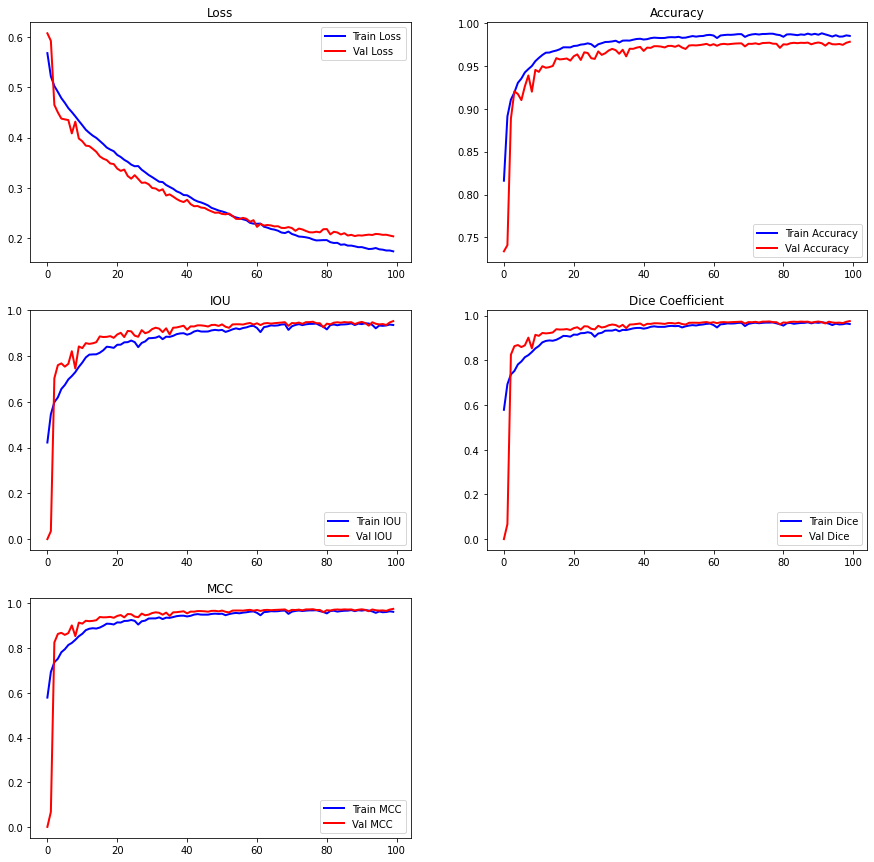

In [ ]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_acc = history.history['accuracy']
epoch_val_acc = history.history['val_accuracy']
epoch_jac = history.history['IOU']
epoch_val_jac = history.history['val_IOU']
epoch_dice = history.history['dice_coef']
epoch_val_dice = history.history['val_dice_coef']
epoch_mcc = history.history['mcc']
epoch_val_mcc = history.history['val_mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val IOU')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_dice, 'b-', linewidth=2, label='Train MCC')
plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

### **Prediction on val image**

In [ ]:
rows = 36
columns = 3
count = 1
for image_number in range(0,36):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y = MultiResModel.predict(val_X[image_number:image_number+1])
  # pred_y = pred_y / 255.
  # pred_y = scaler.fit_transform(pred_y.reshape(-1, pred_y.shape[-1])).reshape(pred_y.shape)

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y[0]))
  plt.title('Segmented')
  count += 3

  print("IOU Score: {0} \nDice Coefficent: {1} \nMCC: {2}".format(IOU(val_Y[image_number:image_number+1], pred_y), dice_coef(val_Y[image_number:image_number+1], pred_y), mcc(val_Y[image_number:image_number+1], pred_y)))

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **Prediction on test image**

In [ ]:
rows = 36
columns = 3
count = 1
for image_number in range(0,35):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y = MultiResModel.predict(test_X[image_number:image_number+1])
  # pred_y = pred_y / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(test_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(test_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y[0]))
  plt.title('Segmented')
  count += 3

  print("IOU Score: {0} \nDice Coefficent: {1} \nMCC: {2}".format(IOU(test_Y[image_number:image_number+1], pred_y), dice_coef(test_Y[image_number:image_number+1], pred_y), mcc(test_Y[image_number:image_number+1], pred_y)))

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **Loading weights and testing**

In [ ]:
MultiResModel_test = MultiResUnetBP(height=256, width=256, n_channels=3)
MultiResModel_test.load_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-1500images-bp-100epochs.tf')

In [ ]:
rows = 36
columns = 3
count = 1
for image_number in range(0,36):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y = MultiResModel_test.predict(val_X[image_number:image_number+1])

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y[0]))
  plt.title('Segmented')
  count += 3

  print("IOU Score: {0} \nDice Coefficent: {1} \nMCC: {2}".format(IOU(val_Y[image_number:image_number+1], pred_y), dice_coef(val_Y[image_number:image_number+1], pred_y), mcc(val_Y[image_number:image_number+1], pred_y)))

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
rows = 36
columns = 3
count = 1
for image_number in range(0,36):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y = MultiResModel_test.predict(test_X[image_number:image_number+1])
  # pred_y_MCC = pred_y_MCC / 255.
  

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(test_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(test_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y[0]))
  plt.title('Segmented')
  count += 3

  print("IOU Score: {0} \nDice Coefficent: {1} \nMCC: {2}".format(IOU(test_Y[image_number:image_number+1], pred_y), dice_coef(test_Y[image_number:image_number+1], pred_y), mcc(test_Y[image_number:image_number+1], pred_y)))

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

### **Filters (32, 64, 128, 256)**

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    MultiResModel = Model(inputs=[inputs], outputs=[conv10])

    return MultiResModel

In [ ]:
MultiResModel_FiltersNotBP = MultiResUnet(height=256, width=256, n_channels=3)

In [ ]:
MultiResModel_FiltersNotBP.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)

In [ ]:
# Check how to store callbacks as JSON (callbacks should store all performance metrics and loss for each epoch)
history_2 = MultiResModel_FiltersNotBP.fit(x = train_X_scaler, y = train_Y_scaler, validation_data = (val_X, val_Y), batch_size = 8, epochs = 100, verbose = 1)

Epoch 1/100
194/194 [==============================] - 89s 405ms/step - loss: 0.5953 - IOU: 0.3576 - mcc: 0.4370 - dice_coef: 0.5098 - accuracy: 0.7588 - val_loss: 0.6388 - val_IOU: 0.0033 - val_mcc: -0.0375 - val_dice_coef: 0.0066 - val_accuracy: 0.7258
Epoch 2/100
194/194 [==============================] - 77s 397ms/step - loss: 0.5314 - IOU: 0.5056 - mcc: 0.6202 - dice_coef: 0.6576 - accuracy: 0.8747 - val_loss: 0.6056 - val_IOU: 0.0226 - val_mcc: 0.1112 - val_dice_coef: 0.0442 - val_accuracy: 0.7385
Epoch 3/100
194/194 [==============================] - 77s 397ms/step - loss: 0.5102 - IOU: 0.5656 - mcc: 0.6766 - dice_coef: 0.7097 - accuracy: 0.8995 - val_loss: 0.4798 - val_IOU: 0.6810 - val_mcc: 0.7447 - val_dice_coef: 0.8102 - val_accuracy: 0.8944
Epoch 4/100
194/194 [==============================] - 77s 397ms/step - loss: 0.4969 - IOU: 0.5986 - mcc: 0.7067 - dice_coef: 0.7382 - accuracy: 0.9117 - val_loss: 0.4560 - val_IOU: 0.7318 - val_mcc: 0.7891 - val_dice_coef: 0.8451 - val_

In [ ]:
MultiResModel_FiltersNotBP.save_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-allimages-100epochs.h5')
MultiResModel_FiltersNotBP.save_weights('/content/drive/MyDrive/airs-minisample/weights/multires-pro-allimages-100epochs.tf')

### **Graph**

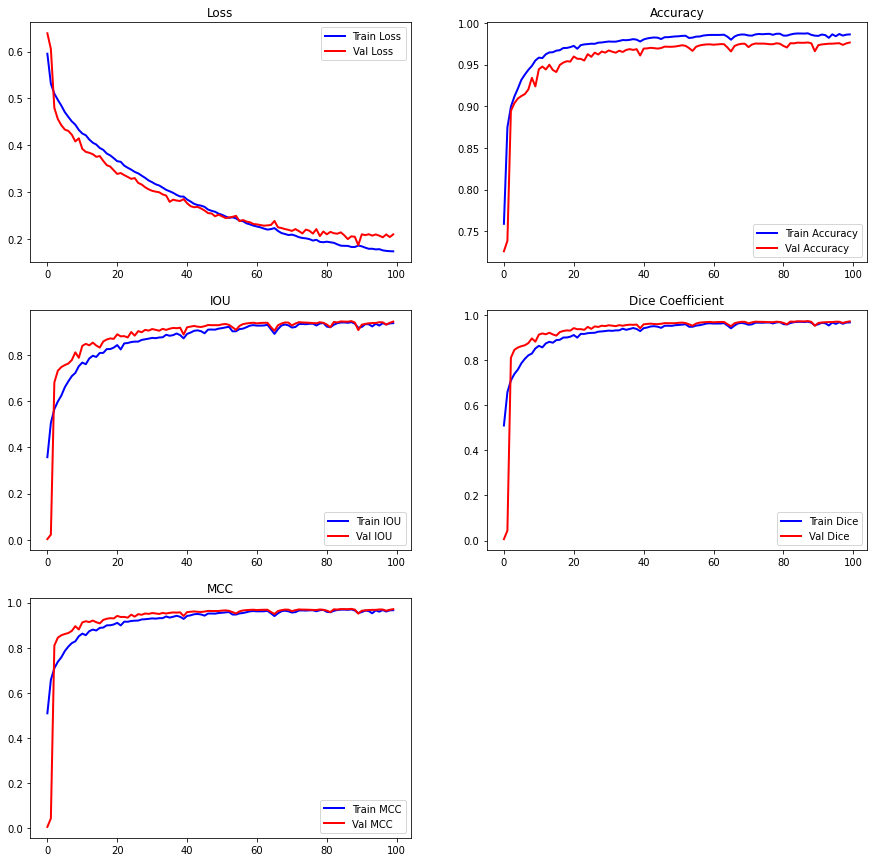

In [ ]:
# Check how loss & mae went down
epoch_loss = history_2.history['loss']
epoch_val_loss = history_2.history['val_loss']
epoch_acc = history_2.history['accuracy']
epoch_val_acc = history_2.history['val_accuracy']
epoch_jac = history_2.history['IOU']
epoch_val_jac = history_2.history['val_IOU']
epoch_dice = history_2.history['dice_coef']
epoch_val_dice = history_2.history['val_dice_coef']
epoch_mcc = history_2.history['mcc']
epoch_val_mcc = history_2.history['val_mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val IOU')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_dice, 'b-', linewidth=2, label='Train MCC')
plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

### **Prediction on val image**

In [ ]:
rows = 36
columns = 3
count = 1
for image_number in range(0,36):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y = MultiResModel_FiltersNotBP.predict(val_X[image_number:image_number+1])
  # pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y[0]))
  plt.title('Segmented')
  count += 3

  print("IOU Score: {0} \nDice Coefficent: {1} \nMCC: {2}".format(IOU(val_Y[image_number:image_number+1], pred_y), dice_coef(val_Y[image_number:image_number+1], pred_y), mcc(val_Y[image_number:image_number+1], pred_y)))

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **Prediction on test image**

In [ ]:
rows = 36
columns = 3
count = 1
for image_number in range(0,36):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y = MultiResModel_FiltersNotBP.predict(test_X[image_number:image_number+1])
  # pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(test_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(test_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y[0]))
  plt.title('Segmented')
  count += 3

  print("IOU Score: {0} \nDice Coefficent: {1} \nMCC: {2}".format(IOU(test_Y[image_number:image_number+1], pred_y), dice_coef(test_Y[image_number:image_number+1], pred_y), mcc(test_Y[image_number:image_number+1], pred_y)))

  plt.show()

Output hidden; open in https://colab.research.google.com to view.